# Deep Learning model for football

### Imports

In [64]:
import os
from pathlib import Path
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    multilabel_confusion_matrix,
    accuracy_score,
    f1_score,
    hamming_loss,
    classification_report
)
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import joblib
from scipy.optimize import linear_sum_assignment
from collections import Counter

### getting the path : `root/.../this_repo`

In [65]:
PATH_TO_REPO = Path.cwd().parent.parent

### Checking all the tables

In [66]:
conn = sqlite3.connect(f'{PATH_TO_REPO}/deep_learning_model/data/database.sqlite')
df_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
df_tables
## this dataset is from 9y ago, therefore I will only be using players dataset of 2015 and 2016

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


### Merging datasets df_player and df_player_stats on player_api_id

In [67]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player = df_player[['player_api_id','player_name','height','weight']]
df_player_stats = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

df_merged = pd.merge(df_player, df_player_stats, on='player_api_id')
data_na = df_merged.drop(['id','player_fifa_api_id','date'],axis=1) # drop columns that are not needed
data_na.head(5)

,player_api_id,player_name,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,182.88,187,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,182.88,187,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,182.88,187,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,182.88,187,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,182.88,187,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


### Load a FIFA dataset and keep only relevant columns


In [68]:

def load_and_prepare_data(file_path) -> pd.DataFrame: 
    
    df = pd.read_csv(file_path)
    
    df = df[['short_name', 'player_positions']].rename(columns={
        "short_name": "Name",
        "player_positions": "Position"
    })
    
    return df
data_fifa15 = load_and_prepare_data(f'{PATH_TO_REPO}/deep_learning_model/data/players_15.csv')
data_fifa16 = load_and_prepare_data(f'{PATH_TO_REPO}/deep_learning_model/data/players_16.csv')

/var/folders/h8/2sygs01x551_3fv66_prptrc0000gn/T/ipykernel_69087/442682993.py:3: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/h8/2sygs01x551_3fv66_prptrc0000gn/T/ipykernel_69087/442682993.py:3: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


### cleaning datasets

In [69]:
print('before:',len(data_na))
a = ['_0', None, '5', 'ean', 'o', '1', 'ormal',
       '7', '2', '8', '4', 'tocky', '0', '3', '6', '9', 'es']

b = [None, 'None', 'le', 'norm', 'stoc', 'y']

data_na = data_na[~data_na['defensive_work_rate'].isin(a)]
data_na = data_na[~data_na['attacking_work_rate'].isin(b)]
data = data_na.dropna(axis=0)

print('after',len(data_na))

before: 183978
after 176161


### Quantization

In [70]:
data = data.replace({'low': int(0), 'medium': int(1), 'high': int(2)})
data = data.replace({'left': int(0), 'right': int(1)})
data.sample(5)

/var/folders/h8/2sygs01x551_3fv66_prptrc0000gn/T/ipykernel_69087/1206903638.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'low': int(0), 'medium': int(1), 'high': int(2)})
/var/folders/h8/2sygs01x551_3fv66_prptrc0000gn/T/ipykernel_69087/1206903638.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'left': int(0), 'right': int(1)})


,player_api_id,player_name,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
39810,108572,David Lomban,187.96,185,69.0,73.0,1,1,1,37.0,...,47.0,44.0,64.0,74.0,63.0,5.0,12.0,12.0,15.0,14.0
73688,409193,Issiaga Sylla,180.34,165,68.0,72.0,0,2,1,69.0,...,66.0,47.0,63.0,64.0,64.0,13.0,13.0,10.0,8.0,12.0
18915,39148,Baptiste Ulens,177.80,152,61.0,62.0,0,2,1,63.0,...,62.0,48.0,59.0,58.0,61.0,6.0,15.0,14.0,6.0,15.0
19045,24978,Barry Ferguson,177.80,163,68.0,68.0,1,0,2,62.0,...,67.0,64.0,71.0,73.0,69.0,11.0,11.0,10.0,15.0,11.0
30734,103218,Ciprian Tatarusanu,195.58,194,72.0,72.0,1,1,1,25.0,...,28.0,25.0,25.0,25.0,25.0,71.0,72.0,69.0,78.0,74.0


### Remove duplicates
The dataset has multiples inputs of each player because 1 player might have played multiple matches in different seasons. Therefore, I will remove the duplicates and keep mean values for each player.

In [71]:
# Get numeric columns
numeric_columns = data_na.select_dtypes(include=[np.number]).columns.tolist()

# Check for non-numeric values in numeric columns
for col in numeric_columns:
    # Identify values that cannot be converted to float
    invalid_entries = data_na[~pd.to_numeric(data_na[col], errors='coerce').notnull()][col].unique()
    
    if len(invalid_entries) > 0:
        print(f"Invalid values found in {col}: {invalid_entries}")
        
for col in numeric_columns:
    # Convert problematic values to NaN
    data_na[col] = pd.to_numeric(data_na[col], errors='coerce')

# Now handle NaNs (e.g., drop them or fill with mean/median)
data_na.dropna(subset=numeric_columns, inplace=True)



In [72]:
df_mean = data.groupby(['player_name'],as_index=False).mean()
df_mean.sample(5)

,player_name,player_api_id,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
6032,Mario Matos,148297.0,185.42,181.0,53.000000,58.200000,0.0,1.000000,1.000000,19.000000,...,16.400000,14.000000,11.000000,9.000000,12.000000,56.600000,47.000000,51.400000,51.000000,57.600000
4300,Jeroen Tesselaar,166065.0,182.88,163.0,62.733333,67.800000,0.0,1.866667,1.000000,61.933333,...,40.133333,51.533333,62.133333,64.733333,62.466667,6.133333,12.133333,14.133333,15.133333,6.133333
6432,Maxime Le Marchand,173952.0,185.42,170.0,63.380952,71.238095,0.0,1.000000,1.095238,51.428571,...,41.714286,41.523810,68.190476,66.380952,63.809524,11.190476,13.285714,17.952381,7.857143,15.095238
8940,Tayfun Pektuerk,97731.0,175.26,165.0,63.125000,72.625000,0.0,1.000000,1.000000,45.500000,...,60.500000,58.000000,17.500000,25.750000,22.500000,13.000000,15.000000,9.000000,9.000000,13.000000
9465,Warner Hahn,352003.0,198.12,187.0,70.000000,77.625000,1.0,1.000000,1.000000,20.250000,...,32.750000,23.750000,23.750000,22.500000,23.500000,73.000000,66.500000,64.500000,67.750000,76.000000


### Changing names
Changing names to the same way as it is at the fifa dataset

In [73]:
def Change_names(df):
    player_names = list(df['player_name'].values)

    new_column = []
    for name in player_names:
        complete_name = name.split()

        if len(complete_name) == 1:
            new_column.append(complete_name[0])

        if len(complete_name) != 1:
            nickname = complete_name[1:]
            nickname = " ".join(nickname)
            inicial = complete_name[0][0] + "."
            short_nickname = inicial + " " + str(nickname)
            new_column.append(short_nickname)

    df = df.rename(columns={"player_name": "old_name"})
    df.insert(loc=0, column='Name', value=new_column)
    df = df.drop(['old_name'], axis=1)
    print('total data', len(df))

    return df

df_changed = Change_names(data)
df_changed

total data 176161


,Name,player_api_id,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,A. Appindangoye,505942,182.88,187,67.0,71.0,1,1,1,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,A. Appindangoye,505942,182.88,187,67.0,71.0,1,1,1,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,A. Appindangoye,505942,182.88,187,62.0,66.0,1,1,1,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,A. Appindangoye,505942,182.88,187,61.0,65.0,1,1,1,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,A. Appindangoye,505942,182.88,187,61.0,65.0,1,1,1,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,Z. Misimovic,39902,180.34,176,83.0,85.0,1,1,0,84.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,Z. Misimovic,39902,180.34,176,78.0,80.0,1,1,0,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,Z. Misimovic,39902,180.34,176,77.0,80.0,1,1,0,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,Z. Misimovic,39902,180.34,176,78.0,81.0,1,1,0,74.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


In [74]:
df_changed.columns

Index(['Name', 'player_api_id', 'height', 'weight', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

### Setting up the dateset
- Merging 2014 and 2015 datasets, 
- create a new column that counts the number of positions,
- group by Name and get the index of the row with the max Position_count 

In [75]:
df_fifa = pd.merge(data_fifa15, data_fifa16, on='Name', how='inner')
df_fifa = df_fifa.drop(['Position_x'],axis=1)
df_fifa = df_fifa.rename(columns={"Position_y": "Position"})
df_fifa['Position_count'] = df_fifa['Position'].str.split(',').str.len()

df_fifa['Position_count'] = df_fifa['Position'].str.split(',').str.len()
idx = df_fifa.groupby('Name')['Position_count'].idxmin()
df_filtered = df_fifa.loc[idx]

idx = df_fifa.groupby('Name')['Position_count'].idxmin()
df_filtered_ = df_filtered.drop('Position_count', axis=1)

df_final = pd.merge(df_filtered_, df_changed, on='Name', how='right')
print('data count:',len(df_final))
df_final.head(6)


data count: 176161


,Name,Position,player_api_id,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,A. Appindangoye,NaN,505942,182.88,187,67.0,71.0,1,1,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,A. Appindangoye,NaN,505942,182.88,187,67.0,71.0,1,1,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,A. Appindangoye,NaN,505942,182.88,187,62.0,66.0,1,1,1,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,A. Appindangoye,NaN,505942,182.88,187,61.0,65.0,1,1,1,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,A. Appindangoye,NaN,505942,182.88,187,61.0,65.0,1,1,1,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,A. Cresswell,LB,155782,170.18,146,74.0,76.0,0,2,1,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


### Reducing barely used positions
replacing 'LWB' with 'RB', 'RWB' with 'RB', and 'CF' with 'ST'.

In [76]:
def transform_position(positions):
    positions = positions.split(', ') # split multiple positions by comma and space
    positions = [p.replace('LWB', 'RB').replace('RWB', 'RB').replace('CF', 'ST') for p in positions] # transform values
    return ', '.join(positions) # join the transformed values with comma and space

df_positions = df_final.dropna()
df_positions['Position'] = df_positions['Position'].apply(transform_position)

/var/folders/h8/2sygs01x551_3fv66_prptrc0000gn/T/ipykernel_69087/2648787674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions['Position'] = df_positions['Position'].apply(transform_position)


### Removing goalkeeper
Goalkeeper has no use in this model. the goalkeeper will always be the goalkeeper, so it is not useful to predict the other positions in the field

In [77]:
df_positions= df_positions[df_positions['Position'] != 'GK']

### adjusting positions optimized for the model training

In [78]:
y_list = df_positions[['Name','Position']]
y_list = y_list[y_list['Position'] != 'GK']
positions = y_list['Position'].str.get_dummies(sep=', ')
df_y = pd.concat([y_list['Name'], positions], axis=1)
df_y.sample(10)

,Name,CAM,CB,CDM,CM,LB,LM,LW,RB,RM,RW,ST
129971,O. Shevelyukhin,0,1,0,0,0,0,0,0,0,0,0
90077,K. Linetty,0,0,1,0,0,0,0,0,0,0,0
127942,N. Reo-Coker,0,0,1,0,0,0,0,1,0,0,0
56697,F. Zuculini,0,0,0,1,0,0,0,0,1,0,0
119010,M. Efir,0,0,0,0,0,0,0,0,0,0,1
75995,J. Makoun,0,0,1,1,0,0,0,0,0,0,0
157502,S. Bamba,0,1,0,0,0,0,0,0,0,0,0
64806,G. Gillet,0,0,1,1,0,0,0,1,0,0,0
159274,S. Hendrie,0,0,0,0,1,0,0,0,0,0,0
110908,M. Vermijl,0,0,0,0,1,0,0,1,0,0,0


In [79]:
df_y.columns.to_list()

['Name', 'CAM', 'CB', 'CDM', 'CM', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'ST']

In [80]:
positions, count_positions= [], []
for i in df_y.columns[1:]:
    positions.append(i)
for j in positions:
    count_positions.append(df_y[j].sum())
print(count_positions)

[np.int64(11885), np.int64(17948), np.int64(14797), np.int64(19322), np.int64(9921), np.int64(12419), np.int64(4286), np.int64(10924), np.int64(12684), np.int64(4602), np.int64(17513)]


### Checking if classes are balanced
The dataset is not balanced, but it is not a problem for the model training. The model will learn to predict the most common positions first and then the less common positions.

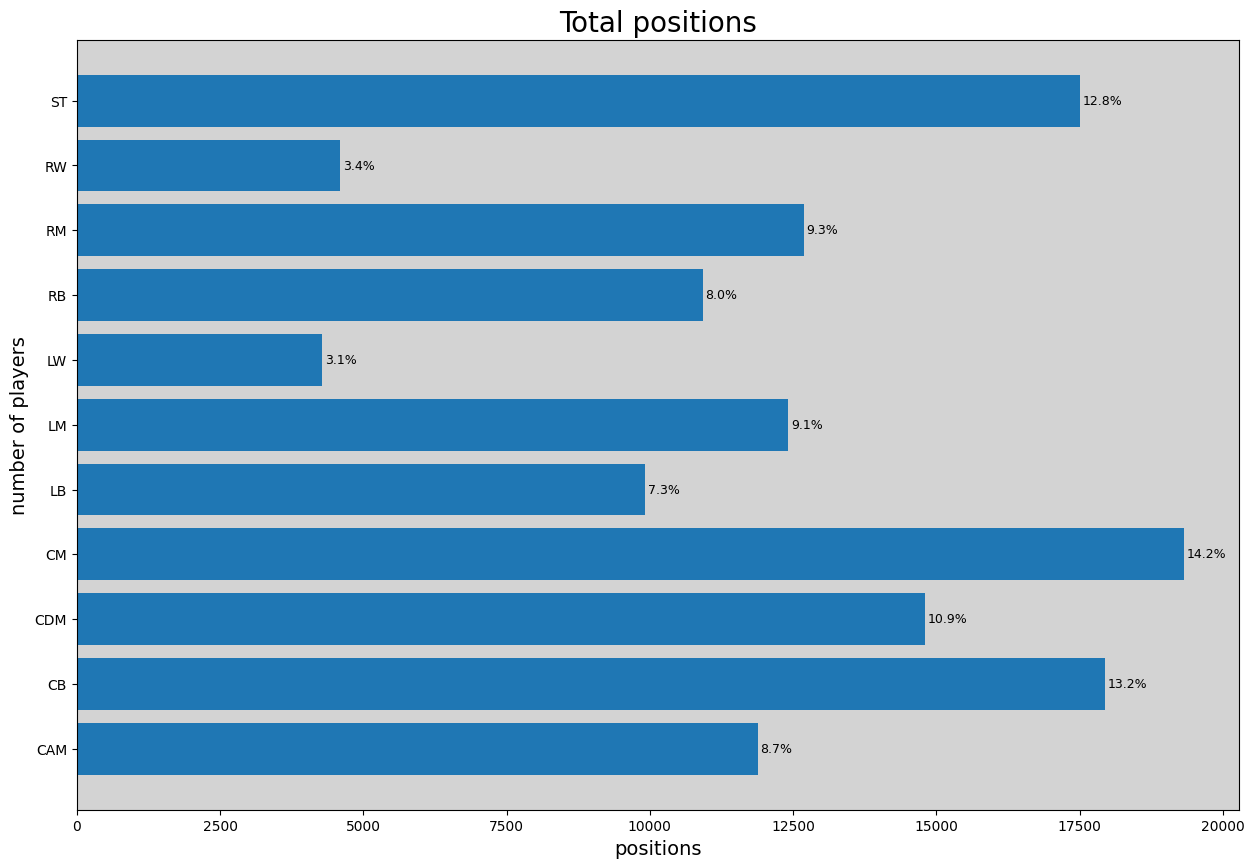

In [81]:
fig,ax = plt.subplots()
fig.set_size_inches(15,10)

ax.barh(positions, count_positions)
plt.title('Total positions',fontsize=20)
plt.xlabel('positions',fontsize=14)
plt.ylabel('number of players',fontsize=14)

ax.set_facecolor('lightgrey')
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{h/sum(count_positions)*100:.1f}%" if h>0 else '' for h in i.datavalues], fontsize=9, padding=2)

plt.show()

### Balancing classes

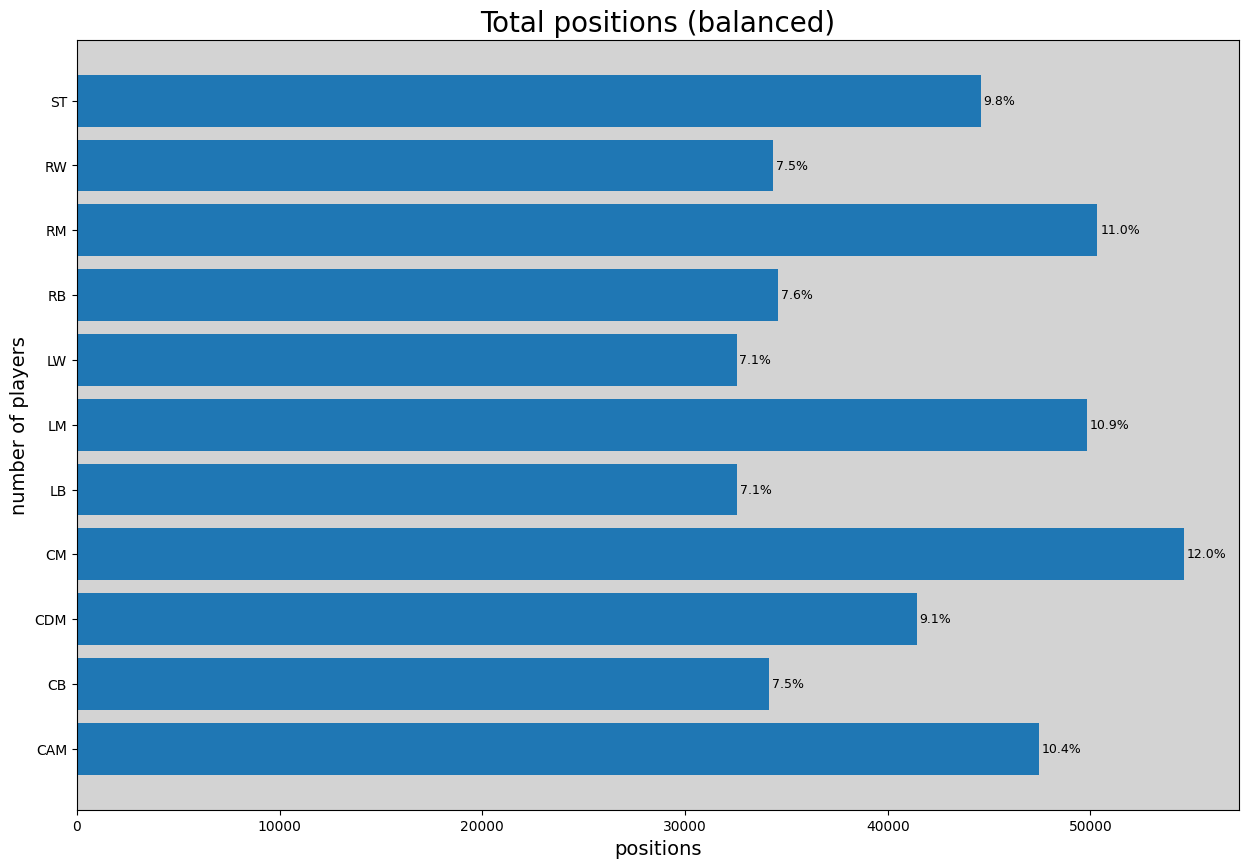

In [82]:
target_cols = df_y.columns[1:] # ignores column 'Name'
max_size = df_y[target_cols].sum().max()

df_y_balanced = pd.DataFrame()

for col in target_cols:
    subset = df_y[df_y[col] == 1]
    upsampled = resample(subset, replace=True, n_samples=int(max_size), random_state=42)
    df_y_balanced = pd.concat([df_y_balanced, upsampled])


positions, count_positions = [], []
for i in df_y_balanced.columns[1:]:
    positions.append(i)
for j in positions:
    count_positions.append(df_y_balanced[j].sum())

# chart

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.barh(positions, count_positions)
plt.title('Total positions (balanced)', fontsize=20)
plt.xlabel('positions', fontsize=14)
plt.ylabel('number of players', fontsize=14)

ax.set_facecolor('lightgrey')
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{h/sum(count_positions)*100:.1f}%" if h > 0 else '' for h in i.datavalues], fontsize=9, padding=2)

plt.show()


### Creating new features for the model

In [83]:
def NewFeatures(X):
  # Creating New variables
  # Body Mass Index
  X['wh'] = (X['weight'] + X['height']) / 2.0

  # Finishing
  X["finishing_acc"] = (X["finishing"] + X["heading_accuracy"] + X["shot_power"])/3.0

  # Skills
  X['skills'] = (X['crossing'] + X['dribbling'] + X['curve'] + X['ball_control']) / 3.0

  # Movement
  X['movement'] = (X['acceleration'] + X['sprint_speed'] + X['agility']+
                  + X['balance'] + X['stamina']) /5.0

  # Attacking
  X['attacking_rating'] = (X['crossing'] + X['finishing'] + X['heading_accuracy'] +
                              X['short_passing'] + X['volleys']) / 5.0

  # DEF Rates
  X['defensive_rating'] = (X['marking'] + X['standing_tackle'] + X['sliding_tackle']) / 3.0


  return X

### Split data

In [84]:
y_name = df_positions['Name']
y_pos = df_y_balanced.drop(['Name'],axis=1)
y_api = df_positions['player_api_id']
X = NewFeatures(df_positions.copy())
X_reduced = X[['weight','height','wh', 'movement', 'finishing_acc', 'skills', 'defensive_rating']]

X_reduced.columns

Index(['weight', 'height', 'wh', 'movement', 'finishing_acc', 'skills',
       'defensive_rating'],
      dtype='object')

### Class balance for axis + splitting data
I balanced the y columns, but that gives us an unbalenced amount for the x columns, so I will balance the x columns too and combine it

In [85]:
X_features = NewFeatures(df_positions.copy())
X_features = X_features[['Name', 'weight', 'height', 'wh', 'movement', 'finishing_acc', 'skills', 'defensive_rating']]

data_balanced = pd.merge(df_y_balanced, X_features, on='Name', how='left')
data_balanced.dropna(inplace=True)

feature_cols = ['weight','height','wh', 'movement', 'finishing_acc', 'skills', 'defensive_rating']
position_cols = y_pos.columns # Colunas de posição que você já tinha

X_final = data_balanced[feature_cols]
y_final = data_balanced[position_cols]


X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

### Standarization 0->1

In [86]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X_reduced.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_reduced.columns)

### Checking the relevance of the chosen features
- in  previous versions I checked every class, this is now a simpllified version with only the most relevant features

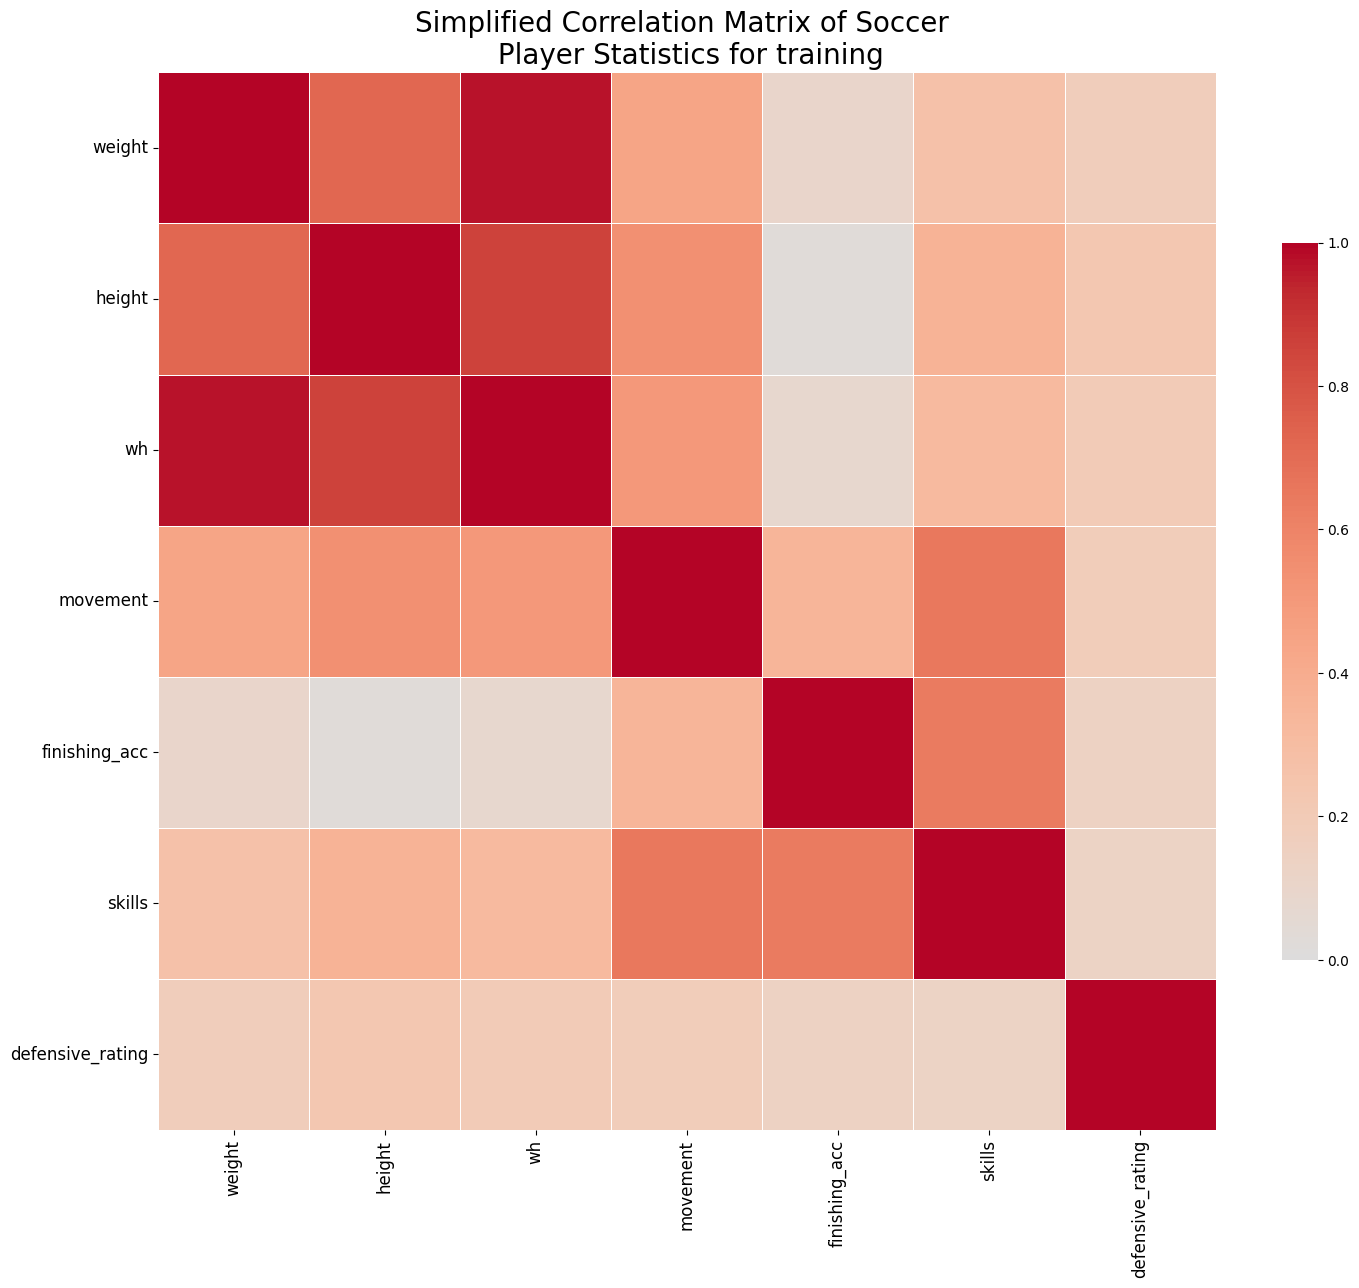

In [88]:
cols = X_train.columns.tolist()
#tirar performance index 
corr = abs(X_train[cols].corr())

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', vmin=0, vmax=1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"fontsize":9})
ax.set_xticklabels(cols, rotation=90, fontsize=12)
ax.set_yticklabels(cols, rotation=0, fontsize=12)
plt.title("Simplified Correlation Matrix of Soccer \n Player Statistics for training", fontsize=20)
plt.tight_layout()
plt.show()

In [89]:
output_dir = Path(f'{PATH_TO_REPO}/deep_learning_model/data/training_data/')

X_train_df.to_csv(output_dir / 'X_train.csv', index=False)
y_train.to_csv(output_dir / 'y_train.csv', index=False)
X_test_df.to_csv(output_dir / 'X_test.csv', index=False)
y_test.to_csv(output_dir / 'y_test.csv', index=False)
scaler = MinMaxScaler()

joblib.dump(scaler, output_dir / 'scaler.pkl')

['/Users/daniel.briquez/Documents/git_repos_pessoal/eita/FootballTatics-BackEnd/deep_learning_model/data/training_data/scaler.pkl']

### Building the model with keras

In [90]:
# This trainng was moved to: deep_learning_model/train_model.py
# it took around 10 hours to train the model, so I wans't recommended to run in from the jupyter cell

### Scores

In [91]:
X_test = pd.read_csv(output_dir / 'X_test.csv')
y_test = pd.read_csv(output_dir / 'y_test.csv')
#load model
pi2025_v1 = load_model(f'{PATH_TO_REPO}/deep_learning_model/models/modelspi2025_v11.h5')
output_dir = Path(f'{PATH_TO_REPO}/deep_learning_model/data/training_data/')
y_pred_probs = pi2025_v1.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)


f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"F1 Score (macro): {f1:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")


10961/36754 ━━━━━━━━━━━━━━━━━━━━ 12s 466us/step

KeyboardInterrupt: 

### evaluating model

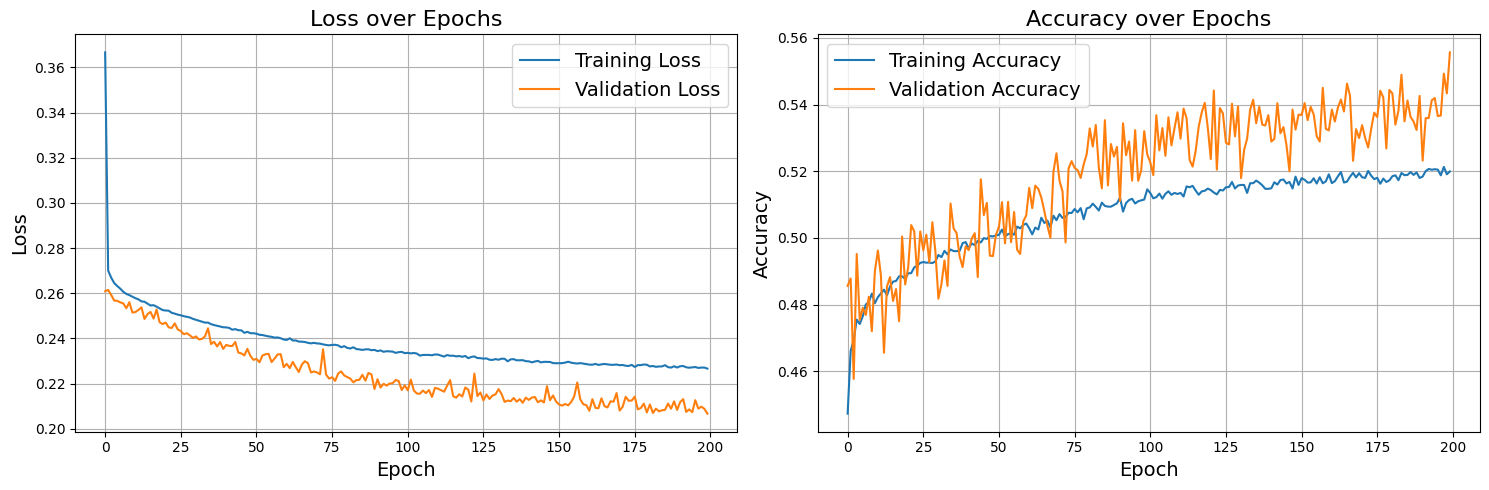

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io

history = pd.read_csv(f"{PATH_TO_REPO}/deep_learning_model/data/history.csv")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot loss on the first subplot
# ADAPTED: Access DataFrame columns directly using history['column_name']
ax1.plot(history['loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True)

# Plot accuracy on the second subplot
# ADAPTED: Access DataFrame columns directly using history['column_name']
ax2.plot(history['accuracy'], label='Training Accuracy')
ax2.plot(history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

### saving scalers

In [94]:
#model_path = f'{PATH_TO_REPO}/deep_learning_model/models/modelspi2025_v6.h5'
scaler_others_path = f'{PATH_TO_REPO}/deep_learning_model/scalers/scaler_others.pkl'
scaler_wh_path = f'{PATH_TO_REPO}/deep_learning_model/scalers/scaler_wh.pkl'
# Assuming you used StandardScaler for feature scaling

scaler = StandardScaler()
scaler.fit(X_train) 

joblib.dump(scaler, scaler_wh_path)

['/Users/daniel.briquez/Documents/git_repos_pessoal/eita/FootballTatics-BackEnd/deep_learning_model/scalers/scaler_wh.pkl']

# Main functions

1.  suggests best players for a given position


In [2]:
# ==============================================================================
# SEÇÃO 1: IMPORTAÇÃO DE BIBLIOTECAS
# ==============================================================================
import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning e Deep Learning
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib

# ==============================================================================
# SEÇÃO 2: FUNÇÕES AUXILIARES (INTERNAS)
# ==============================================================================

# ALTERADO: A função agora espera um DataFrame para garantir a consistência das features.
def _predict_player_positions(player_df, scaler, model):
    """
    Usa o modelo de IA para prever as probabilidades de posição de um jogador.
    Recebe um DataFrame de uma linha para garantir a consistência das colunas.
    """
    posicoes_modelo = ['CAM', 'CB', 'CDM', 'CM', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'ST']
    
    # Aplica o escalonamento no DataFrame, que preserva a ordem das colunas
    input_scaled = scaler.transform(player_df)
    
    # Faz a predição com o modelo de deep learning
    predictions = model.predict(input_scaled, verbose=0)
    
    return dict(zip(posicoes_modelo, predictions.flatten()))

def _mapear_posicao_para_grupo(posicao_str):
    """
    Função auxiliar para traduzir a posição prevista pelo modelo para um grupo tático.
    """
    posicao_upper = posicao_str.upper()
    if 'CB' in posicao_upper or 'LB' in posicao_upper or 'RB' in posicao_upper:
        return 'Defensor'
    if 'CDM' in posicao_upper:
        return 'Volante'
    if 'CM' in posicao_upper or 'CAM' in posicao_upper or 'LM' in posicao_upper or 'RM' in posicao_upper:
        return 'Meia'
    if 'LW' in posicao_upper or 'RW' in posicao_upper:
        return 'Ponta'
    if 'ST' in posicao_upper:
        return 'Atacante'
    return 'Outro'

def _encontrar_formacao_por_contagem(group_counts):
    """
    Função auxiliar que contém a lógica de regras para decidir a formação
    com base na contagem de jogadores por grupo tático.
    """
    defs = group_counts.get('Defensor', 0)
    vols = group_counts.get('Volante', 0)
    meias = group_counts.get('Meia', 0)
    pontas = group_counts.get('Ponta', 0)
    atacs = group_counts.get('Atacante', 0)

    # Lógica principal de decisão da formação
    if defs >= 5:
        return '5-4-1'
    if defs == 4:
        if (vols + meias) >= 3 and (pontas + atacs) >= 3:
            return '4-3-3'
        if (vols + meias) >= 4 and (pontas + atacs) >= 2:
            return '4-4-2'
        if (vols + meias) >= 5 and (pontas + atacs) >= 1:
            return '4-5-1'
        if vols >= 2 and meias >= 1 and pontas >= 2 and atacs >= 1:
             return '4-2-3-1'
        return '4-4-2'
    if defs <= 3:
        if (vols + meias) >= 5 and (pontas + atacs) >= 2:
            return '3-5-2'
        if (vols + meias) >= 4 and (pontas + atacs) >= 3:
            return '3-4-3'
        return '3-5-2'
        
    return '4-4-2'


# ==============================================================================
# SEÇÃO 3: FUNÇÃO PRINCIPAL
# ==============================================================================

def recomendar_formacao_com_ia(lista_jogadores, model, scaler):
    """
    Recebe uma lista de jogadores com seus atributos, usa um modelo de IA para
    avaliar as melhores posições e recomenda a formação tática para o time.
    """
    jogadores_de_linha = [p for p in lista_jogadores if not p.get('goleiro', False)]
    jogadores_com_posicao = []

    # IMPORTANTE: A lista de nomes de colunas deve ser EXATAMENTE A MESMA e
    # na MESMA ORDEM que a usada no seu notebook de treinamento.
    # Verifique seu notebook e ajuste esta lista se necessário.
    nomes_features_treino = [
        'weight', 'height', 'wh', 'movement', 'finishing_acc', 'skills', 'defensive_rating'
    ]

    for jogador in jogadores_de_linha:
        altura = jogador['altura']
        peso = jogador['peso']
        velocidade = jogador['velocidade']
        passe = jogador['passe']
        chute = jogador['chute']
        defesa = jogador['defesa']
        
        # --- ALTERAÇÃO PRINCIPAL ---
        # Recriamos as features em um DataFrame do Pandas para garantir que os nomes
        # e a ordem das colunas sejam consistentes com o treinamento.
        # Isso corrige o 'UserWarning'.
        wh = (peso + altura) / 2.0
        
        jogador_df = pd.DataFrame([[
            peso, altura, wh, velocidade, chute, passe, defesa
        ]], columns=nomes_features_treino)
        # --- FIM DA ALTERAÇÃO ---
        
        # A função auxiliar agora recebe o DataFrame
        probabilidades = _predict_player_positions(jogador_df, scaler, model)
        
        melhor_posicao = max(probabilidades, key=probabilidades.get)
        grupo_principal = _mapear_posicao_para_grupo(melhor_posicao)
        
        jogadores_com_posicao.append({
            'nome': jogador['nome'],
            'posicao_sugerida': melhor_posicao,
            'grupo_tatico': grupo_principal
        })

    contagem_grupos = Counter([p['grupo_tatico'] for p in jogadores_com_posicao])
    formacao_sugerida = _encontrar_formacao_por_contagem(contagem_grupos)
    
    resultado_final = {
        'formacao_sugerida': formacao_sugerida,
        'jogadores': jogadores_com_posicao
    }
    
    return resultado_final


# ==============================================================================
# SEÇÃO 4: EXECUÇÃO (EXEMPLO DE USO)
# ==============================================================================

if __name__ == '__main__':
    
    time_completo = [
        {"nome": "Goleiro 1", "altura": 190, "peso": 88, "velocidade": 5, "chute": 2, "passe": 6, "defesa": 8, "goleiro": True},
        {"nome": "Defensor Central 1", "altura": 188, "peso": 85, "velocidade": 6, "chute": 3, "passe": 6, "defesa": 9, "goleiro": False},
        {"nome": "Defensor Central 2", "altura": 186, "peso": 82, "velocidade": 6, "chute": 4, "passe": 7, "defesa": 9, "goleiro": False},
        {"nome": "Lateral Rápido", "altura": 178, "peso": 75, "velocidade": 9, "chute": 6, "passe": 7, "defesa": 7, "goleiro": False},
        {"nome": "Lateral Defensivo", "altura": 180, "peso": 77, "velocidade": 7, "chute": 5, "passe": 7, "defesa": 8, "goleiro": False},
        {"nome": "Volante Cão de Guarda", "altura": 185, "peso": 80, "velocidade": 6, "chute": 6, "passe": 8, "defesa": 9, "goleiro": False},
        {"nome": "Meia Armador", "altura": 175, "peso": 70, "velocidade": 7, "chute": 8, "passe": 10, "defesa": 5, "goleiro": False},
        {"nome": "Meia Versátil", "altura": 180, "peso": 76, "velocidade": 8, "chute": 8, "passe": 8, "defesa": 7, "goleiro": False},
        {"nome": "Ponta Veloz", "altura": 176, "peso": 68, "velocidade": 10, "chute": 8, "passe": 8, "defesa": 3, "goleiro": False},
        {"nome": "Ponta Driblador", "altura": 177, "peso": 69, "velocidade": 10, "chute": 7, "passe": 8, "defesa": 3, "goleiro": False},
        {"nome": "Centroavante Finalizador", "altura": 187, "peso": 84, "velocidade": 8, "chute": 10, "passe": 6, "defesa": 2, "goleiro": False}
    ]

    try:
        # --- ATENÇÃO: Verifique se estes caminhos estão corretos para sua estrutura de pastas ---
        PATH_TO_REPO = Path.cwd().parent.parent
        model_path = f'{PATH_TO_REPO}/deep_learning_model/models/modelspi2025_v12.h5'
        scaler_path = f'{PATH_TO_REPO}/deep_learning_model/scalers/scaler_wh.pkl' 
        print(f"Tentando carregar modelo de: {model_path}")
        print(f"Tentando carregar scaler de: {scaler_path}")

        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        resultado_ia = recomendar_formacao_com_ia(time_completo, model, scaler)
    
        print("\n--- ANÁLISE TÁTICA DA IA ---")
        print(f"\nFormação Sugerida: {resultado_ia['formacao_sugerida']}")
        
        print("\nPosicionamento Sugerido para os Jogadores de Linha:")
        for jogador in resultado_ia['jogadores']:
            print(f"  - {jogador['nome']:<25} -> Posição: {jogador['posicao_sugerida']:<5} (Grupo: {jogador['grupo_tatico']})")
        print("\n------------------------------")

    except FileNotFoundError as e:
        print(f"\nAVISO: Arquivo de modelo e/ou scaler não encontrado. Erro: {e}")
        print("Verifique os caminhos em 'model_path' e 'scaler_path'.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado durante a execução: {e}")

Tentando carregar modelo de: /Users/daniel.briquez/Documents/git_repos_pessoal/eita/FootballTatics-BackEnd/deep_learning_model/models/modelspi2025_v12.h5
Tentando carregar scaler de: /Users/daniel.briquez/Documents/git_repos_pessoal/eita/FootballTatics-BackEnd/deep_learning_model/scalers/scaler_wh.pkl

--- ANÁLISE TÁTICA DA IA ---

Formação Sugerida: 3-5-2

Posicionamento Sugerido para os Jogadores de Linha:
  - Defensor Central 1        -> Posição: RB    (Grupo: Defensor)
  - Defensor Central 2        -> Posição: CAM   (Grupo: Meia)
  - Lateral Rápido            -> Posição: RM    (Grupo: Meia)
  - Lateral Defensivo         -> Posição: RM    (Grupo: Meia)
  - Volante Cão de Guarda     -> Posição: CAM   (Grupo: Meia)
  - Meia Armador              -> Posição: RM    (Grupo: Meia)
  - Meia Versátil             -> Posição: ST    (Grupo: Atacante)
  - Ponta Veloz               -> Posição: RM    (Grupo: Meia)
  - Ponta Driblador           -> Posição: ST    (Grupo: Atacante)
  - Centroavante F

2. find best tactic for a given team features --> this function was moved to django

In [ ]:
def _mapear_posicao_para_grupo(posicao_str):
    """Função auxiliar para traduzir a posição do JSON para um grupo tático."""
    posicao_lower = posicao_str.lower()
    if 'goleiro' in posicao_lower:
        return 'Goleiro'
    if 'zagueiro' in posicao_lower or 'lateral' in posicao_lower:
        return 'Defensor'
    if 'volante' in posicao_lower:
        return 'Volante'
    if 'meia' in posicao_lower:
        return 'Meia'
    if 'ponta' in posicao_lower:
        return 'Ponta'
    if 'atacante' in posicao_lower or 'centroavante' in posicao_lower:
        return 'Atacante'
    return 'Outro'


def sugerir_taticas_por_time(lista_jogadores, limiares):
    # --- 1. Separação dos jogadores por setor/grupo tático ---
    jogadores_por_grupo = {}
    for jogador in lista_jogadores:
        grupo = _mapear_posicao_para_grupo(jogador['posicao'])
        if grupo not in jogadores_por_grupo:
            jogadores_por_grupo[grupo] = []
        jogadores_por_grupo[grupo].append(jogador)

    resultados = {}

    # --- 2. Lógica de Análise Adaptada para cada Tática ---

    # Tática: Tiki-Taka (baseado em passe)
    meias = jogadores_por_grupo.get('Meia', []) + jogadores_por_grupo.get('Volante', [])
    aptos = [p['nome'] for p in meias if p['passe'] >= limiares['passe_alto']]
    resultados['Tiki-Taka'] = {
        'sugerida': len(aptos) / len(meias) >= 0.6 if meias else False,
        'justificativa': f"{len(aptos)} de {len(meias)} meio-campistas têm passe alto. Jogadores chave: {aptos or 'Nenhum'}. (Obs: Stamina não avaliada)."
    }

    # Tática: Jogada pelas Pontas (baseado em velocidade)
    pontas = jogadores_por_grupo.get('Ponta', [])
    aptos = [p['nome'] for p in pontas if p['velocidade'] >= limiares['velocidade_alta']]
    resultados['Jogada pelas Pontas'] = {
        'sugerida': len(pontas) > 0 and len(aptos) == len(pontas),
        'justificativa': f"Ambos os pontas são velozes. Jogadores chave: {aptos or 'Nenhum'}. (Obs: Drible não avaliado)." if len(pontas) > 0 and len(aptos) == len(pontas) else f"Necessário ter pontas velozes. Apenas {len(aptos)} de {len(pontas)} se encaixam."
    }

    # Tática: Contra-Ataque (velocidade no ataque, passe no meio, defesa sólida)
    ataque = jogadores_por_grupo.get('Atacante', []) + jogadores_por_grupo.get('Ponta', [])
    meio = jogadores_por_grupo.get('Meia', []) + jogadores_por_grupo.get('Volante', [])
    defesa = jogadores_por_grupo.get('Defensor', [])
    
    atac_aptos = [p['nome'] for p in ataque if p['velocidade'] >= limiares['velocidade_alta']]
    meio_aptos = [p['nome'] for p in meio if p['passe'] >= limiares['bom_passe']]
    def_aptos = [p['nome'] for p in defesa if p['defesa'] >= limiares['boa_defesa']]
    
    sugerida = (len(atac_aptos) / len(ataque) >= 0.5 and len(meio_aptos) / len(meio) >= 0.5 and len(def_aptos) / len(defesa) >= 0.7) if all([ataque, meio, defesa]) else False
    resultados['Contra-Ataque'] = {
        'sugerida': sugerida,
        'justificativa': f"Atacantes velozes ({len(atac_aptos)}), meio-campo com bom passe ({len(meio_aptos)}) e defesa sólida ({len(def_aptos)})."
    }

    # Tática: Pressão (Não é possível avaliar sem 'stamina' e 'reação')
    resultados['Pressão'] = {
        'sugerida': False,
        'justificativa': "Não é possível sugerir esta tática, pois os atributos 'stamina' e 'reação' não foram fornecidos."
    }

    # Tática: Conexão Direta (passe da defesa, força/altura do ataque)
    zaga_e_goleiro = jogadores_por_grupo.get('Defensor', []) + jogadores_por_grupo.get('Goleiro', [])
    centroavantes = [p for p in jogadores_por_grupo.get('Atacante', []) if 'centroavante' in p['posicao'].lower()]
    
    def_aptos = [p['nome'] for p in zaga_e_goleiro if p['passe'] >= limiares['passe_alto']]
    # Usando altura como um substituto para força física
    atac_aptos = [p['nome'] for p in centroavantes if p['altura'] >= limiares['altura_atacante']]
    
    sugerida = (len(def_aptos) >= 2 and len(atac_aptos) > 0) if centroavantes else False
    resultados['Conexão Direta'] = {
        'sugerida': sugerida,
        'justificativa': f"Defensores com passe longo de qualidade ({def_aptos or 'Nenhum'}) e centroavantes altos para o pivô ({atac_aptos or 'Nenhum'})."
    }

    # Tática: Retranca Total (defensores e meias com boa defesa, pontas velozes)
    bloco_defensivo = jogadores_por_grupo.get('Defensor', []) + jogadores_por_grupo.get('Meia', []) + jogadores_por_grupo.get('Volante', [])
    pontas_velozes = [p['nome'] for p in jogadores_por_grupo.get('Ponta', []) if p['velocidade'] >= limiares['velocidade_alta']]
    
    def_aptos = [p['nome'] for p in bloco_defensivo if p['defesa'] >= limiares['boa_defesa']]
    
    sugerida = (len(def_aptos) / len(bloco_defensivo) >= 0.7) if bloco_defensivo else False
    resultados['Retranca Total'] = {
        'sugerida': sugerida,
        'justificativa': f"Bloco defensivo sólido com {len(def_aptos)} de {len(bloco_defensivo)} jogadores. Pontas velozes para escape: {pontas_velozes or 'Nenhum'}."
    }

    return resultados


# --- Exemplo de Execução ---
if __name__ == '__main__':
    # Lista de 11 jogadores no formato JSON especificado
    time_completo = [
        { "nome": "Alisson", "camisa": 1, "idade": 32, "altura": 191, "peso": 91, "posicao": "Goleiro", "perna_boa": "DIR", "velocidade": 6, "chute": 5, "passe": 8, "defesa": 2, "goleiro": True },
        { "nome": "Danilo", "camisa": 2, "idade": 33, "altura": 184, "peso": 78, "posicao": "Lateral Direito", "perna_boa": "DIR", "velocidade": 8, "chute": 6, "passe": 8, "defesa": 8, "goleiro": False },
        { "nome": "Thiago Silva", "camisa": 3, "idade": 40, "altura": 183, "peso": 79, "posicao": "Zagueiro", "perna_boa": "DIR", "velocidade": 4, "chute": 5, "passe": 8, "defesa": 9, "goleiro": False },
        { "nome": "Marquinhos", "camisa": 4, "idade": 31, "altura": 183, "peso": 75, "posicao": "Zagueiro", "perna_boa": "DIR", "velocidade": 7, "chute": 5, "passe": 8, "defesa": 9, "goleiro": False },
        { "nome": "A. Telles", "camisa": 6, "idade": 32, "altura": 181, "peso": 72, "posicao": "Lateral Esquerdo", "perna_boa": "ESQ", "velocidade": 8, "chute": 7, "passe": 8, "defesa": 7, "goleiro": False },
        { "nome": "Casemiro", "camisa": 5, "idade": 33, "altura": 185, "peso": 84, "posicao": "Volante", "perna_boa": "DIR", "velocidade": 6, "chute": 8, "passe": 8, "defesa": 9, "goleiro": False },
        { "nome": "Paquetá", "camisa": 8, "idade": 27, "altura": 180, "peso": 72, "posicao": "Meia Central", "perna_boa": "ESQ", "velocidade": 7, "chute": 8, "passe": 8, "defesa": 6, "goleiro": False },
        { "nome": "Neymar", "camisa": 10, "idade": 33, "altura": 175, "peso": 68, "posicao": "Meia Ofensivo", "perna_boa": "DIR", "velocidade": 8, "chute": 8, "passe": 9, "defesa": 4, "goleiro": False },
        { "nome": "Raphinha", "camisa": 7, "idade": 28, "altura": 176, "peso": 68, "posicao": "Ponta Direita", "perna_boa": "ESQ", "velocidade": 9, "chute": 8, "passe": 8, "defesa": 4, "goleiro": False },
        { "nome": "Vini Jr.", "camisa": 11, "idade": 24, "altura": 176, "peso": 73, "posicao": "Ponta Esquerda", "perna_boa": "DIR", "velocidade": 10, "chute": 8, "passe": 8, "defesa": 3, "goleiro": False },
        { "nome": "Richarlison", "camisa": 9, "idade": 28, "altura": 184, "peso": 71, "posicao": "Centroavante", "perna_boa": "DIR", "velocidade": 8, "chute": 9, "passe": 6, "defesa": 4, "goleiro": False }
    ]

    # Definição dos limiares para os atributos simplificados (escala de 1 a 10)
    limiares_simplificados = {
        'passe_alto': 8,
        'bom_passe': 7,
        'velocidade_alta': 9,
        'boa_defesa': 8,
        'altura_atacante': 185 # em cm
    }

    # Chamada da função com os novos dados
    sugestoes = sugerir_taticas_por_time(time_completo, limiares_simplificados)

    # Impressão dos resultados
    print("--- SUGESTÕES DE TÁTICAS PARA O TIME (MODELO SIMPLIFICADO) ---")
    for tatica, info in sugestoes.items():
        if info['sugerida']:
            print("tatica Sugerida: {tatica}")
